In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [34]:
class ReadImage():
    def __init__(self, image_path):
        self.image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        self.bisecting_line = None
        self.slope = None
        self.intercept = None

    def get_bisecting_line(self):
        region_1 = (self.image == 51).astype(np.uint8)
        contours, _ = cv2.findContours(region_1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cornea_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(cornea_contour)
        if M["m00"] != 0:
            cx_up = int(M["m10"] / M["m00"]) 
            cy_up = int(M["m01"] / M["m00"]) 
        else:
            cx_up, cy_up = 0, 0

        region_2 = (self.image == 153).astype(np.uint8) 
        contours, _ = cv2.findContours(region_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cornea_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(cornea_contour)
        if M["m00"] != 0:
            cx_lo = int(M["m10"] / M["m00"]) 
            cy_lo = int(M["m01"] / M["m00"]) 
        else:
            cx_lo, cy_lo = 0, 0

        x_centers = [cx_up, cx_lo]
        y_centers = [cy_up, cy_lo]
        m, b = np.polyfit(x_centers, y_centers, 1)
        x_values = np.array([0, self.image.shape[1]])  # Dynamic x range based on image width
        y_values = m * x_values + b
        self.slope = m
        self.intercept = b
        self.bisecting_line = [x_values, y_values]

        return self.bisecting_line

    def density_center(self):
        tolerance = 150 
        region_width = 100  
        
        slope = self.slope
        intercept = self.intercept

        tear_film = (self.image == 102).astype(np.uint8)

        y_coords, x_coords = np.nonzero(tear_film)

        y_line_coords = slope * x_coords + intercept

        close_to_line_mask = np.abs(y_coords - y_line_coords) <= tolerance
        curved_center_points = np.column_stack((x_coords[close_to_line_mask], y_coords[close_to_line_mask]))

        if len(curved_center_points) == 0:
            return [], []

        center_idx = len(curved_center_points) // 2
        center_x, center_y = curved_center_points[center_idx]

        mask_in_region = (x_coords >= center_x - region_width // 2) & (x_coords <= center_x + region_width // 2)

        central_region_mask = np.abs(y_coords - y_line_coords) <= tolerance
        mask_in_curvature = mask_in_region & central_region_mask

        center_x_coords = x_coords[mask_in_curvature]
        center_y_coords = y_coords[mask_in_curvature]

        total_white_points = np.sum(tear_film > 0)
        center_white_points = len(center_x_coords)
        density = center_white_points / total_white_points if total_white_points > 0 else 0
    
        return density, center_x_coords, center_y_coords


    def density_edge_left(self):
        tear_film = (self.image == 102).astype(np.uint8)
        y_coords, x_coords = np.nonzero(tear_film)

        tolerance = 50 

        left_x = np.min(x_coords)

        left_y = y_coords[np.argmin(x_coords)]

        bottom_left_x = left_x
        bottom_left_y = left_y
        
        bottom_right_x = min(left_x + tolerance, 500) 
        up_left_y = max(left_y - tolerance, 0)

        mask = (x_coords >= bottom_left_x) & (x_coords <= bottom_right_x) & \
           (y_coords >= up_left_y) & (y_coords <= bottom_left_y)

        left_x_coords = x_coords[mask]
        left_y_coords = y_coords[mask]

        total_white_points = np.sum(tear_film > 0)
        edge_white_points = len(left_x_coords)
        density = edge_white_points / total_white_points if total_white_points > 0 else 0
    
        return density, left_x_coords, left_y_coords


    def density_edge_right(self):
        tear_film = (self.image == 102).astype(np.uint8)
        y_coords, x_coords = np.nonzero(tear_film)
        tolerance = 50 

        right_x = np.max(x_coords)

        right_y = y_coords[np.argmax(x_coords)]

        bottom_right_x = right_x
        bottom_right_y = right_y
        
        bottom_left_x = max(right_x - tolerance, 0) 
        up_right_y = max(right_y - tolerance, 0)

        mask = (x_coords >= bottom_left_x) & (x_coords <= bottom_right_x) & \
           (y_coords >= up_right_y) & (y_coords <= bottom_right_y)

        right_x_coords = x_coords[mask]
        right_y_coords = y_coords[mask]

        total_white_points = np.sum(tear_film > 0)
        edge_white_points = len(right_x_coords)
        density = edge_white_points / total_white_points if total_white_points > 0 else 0
    
        return density, right_x_coords, right_y_coords

    def plot_bisecting_line(self):
        x_values, y_values = self.bisecting_line
        plt.imshow(self.image, cmap='gray')
        plt.ylim(self.image.shape[0], 0)
        plt.plot(x_values, y_values, color='blue', linestyle='-', label='Line passing through centers')
        plt.ylim(500, 0)
        plt.title('Cornea with Bisecting Line')
        plt.show()

    def plot_center_highlight(self, x_coords, y_coords):
        plt.imshow(self.image, cmap='gray')

        plt.scatter(x_coords, y_coords, color='yellow', s=1, label='Center Points')

        plt.title("Image with Center Region Points Highlighted")
        plt.legend()
        plt.show()

    def plot_edge_box_left(self, x_coords, y_coords):
        plt.imshow(self.image, cmap='gray')

        for x, y in zip(x_coords, y_coords):
            plt.scatter(x, y, color='yellow', s=1)  
        
        plt.title("Image with Left Box Region Edges Highlighted")
        plt.show()
        

    def plot_edge_box_right(self, x_coords, y_coords):
        plt.imshow(self.image, cmap='gray')

        for x, y in zip(x_coords, y_coords):
            plt.scatter(x, y, color='yellow', s=1) 
        
        plt.title("Image with right Box Region Edges Highlighted")
        plt.show()

    def plot_all(self, center_highlight, left_box, right_box):
        self.plot_bisecting_line()
        self.plot_center_density(center_highlight)
        self.plot_edge_boxes(left_box, right_box)


In [35]:
img1 = ReadImage('SCL_OCT_dataset/label/CKY_OD_1H_img045_outcome.png')
line = img1.get_bisecting_line()
density_c, xc, yc = img1.density_center()
density_l, xl, yl = img1.density_edge_left()
density_r, xr, yr = img1.density_edge_right()

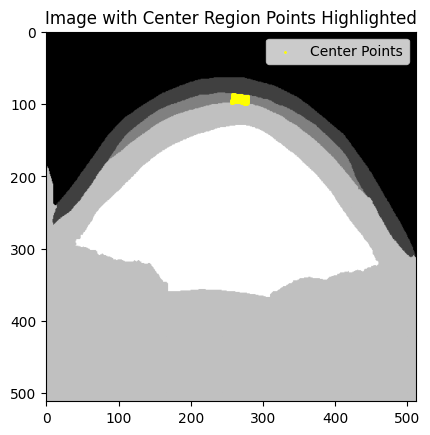

In [36]:
img1.plot_center_highlight(xc, yc)

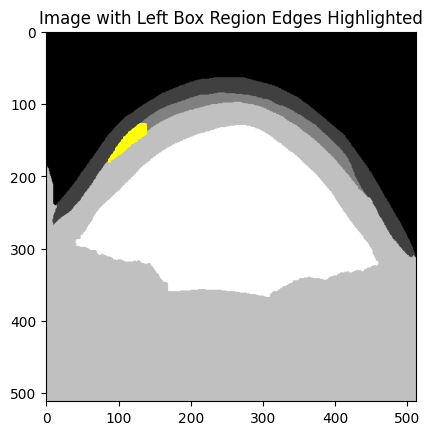

In [37]:
img1.plot_edge_box_left(xl, yl)

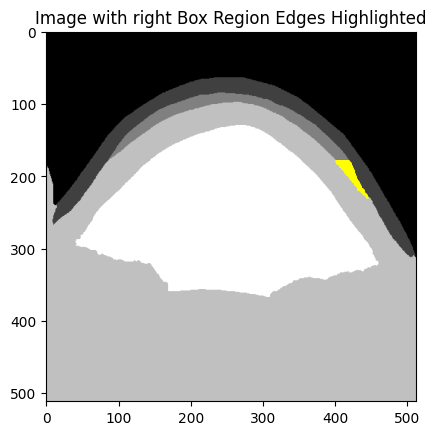

In [38]:
img1.plot_edge_box_right(xr, yr)

# Clustering

In [39]:
import os
import pandas as pd

columns = ['image_name', 'center_thickness', 'right_edge_thickness', 'left_edge_thickness']

image_dir = 'SCL_OCT_dataset/label/'  
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

In [40]:
all_cornea_data = []

for image_file in image_files:
    image_file = 'SCL_OCT_dataset/label/' + image_file
    img1 = ReadImage(image_file)
    line = img1.get_bisecting_line()
    density_c, xc, yc = img1.density_center()
    density_l, xl, yl = img1.density_edge_left()
    density_r, xr, yr = img1.density_edge_right()

    cornea_data = [image_file, density_c, density_r, density_l]
    all_cornea_data.append(cornea_data)

/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_19724/4191981827.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_centers, y_centers, 1)
/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_19724/4191981827.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_centers, y_centers, 1)
/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_19724/4191981827.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_centers, y_centers, 1)
/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_19724/4191981827.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_centers, y_centers, 1)
/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_19724/4191981827.py:31: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_centers, y_centers, 1)
/var/folders/f4/4mwvrr4x2dg6l94x0rks7ypr0000gn/T/ipykernel_19724/4191981827.py:31: RankWarning: Polyfit may be poorly conditi

In [41]:
results_df = pd.DataFrame(all_cornea_data, columns=columns)

In [50]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


def plot_clusters(x, y, cluster_labels, xlabel, ylabel, title):
    plt.scatter(x, y, c=cluster_labels, cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(label='Cluster')
    plt.show()


def get_representative_images(kmeans_model, results_df, feature_columns, n_clusters=2):
    representative_images = []
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(kmeans_model.labels_ == cluster_id)[0]

        cluster_points = results_df.iloc[cluster_indices][feature_columns].values

        centroid = kmeans_model.cluster_centers_[cluster_id]
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        closest_point_index = cluster_indices[np.argmin(distances)]

        representative_image = results_df.iloc[closest_point_index]['image_name']
        representative_images.append(representative_image)
    
    return representative_images

def cluster_center(results_df):
    n_clusters = 2 
    kmeans_center = KMeans(n_clusters=n_clusters, random_state=42)
    results_df['center_cluster'] = kmeans_center.fit_predict(results_df[['center_thickness']])

    plot_clusters(
        results_df['image_name'], 
        results_df['center_thickness'], 
        results_df['center_cluster'], 
        'Image Name', 
        'Center Thickness', 
        'Center Thickness Clusters'
    )
    return get_representative_images(kmeans_center, results_df, ['center_thickness'])

def cluster_left(results_df):
    n_clusters = 2
    kmeans_left = KMeans(n_clusters=n_clusters, random_state=42)
    results_df['left_cluster'] = kmeans_left.fit_predict(results_df[['left_edge_thickness']])

    plot_clusters(
        results_df['image_name'], 
        results_df['left_edge_thickness'], 
        results_df['left_cluster'], 
        'Image Name', 
        'Left Edge Thickness', 
        'Left Edge Thickness Clusters'
    )
    return get_representative_images(kmeans_left, results_df, ['left_edge_thickness'])


def cluster_right(results_df):
    n_clusters = 2
    kmeans_right = KMeans(n_clusters=n_clusters, random_state=42)
    results_df['right_cluster'] = kmeans_right.fit_predict(results_df[['right_edge_thickness']])

    plot_clusters(
        results_df['image_name'], 
        results_df['right_edge_thickness'], 
        results_df['right_cluster'], 
        'Image Name', 
        'Right Edge Thickness', 
        'Right Edge Thickness Clusters'
    )

    return get_representative_images(kmeans_right, results_df, ['right_edge_thickness'])

def cluster_all(results_df):
    n_clusters = 2
    kmeans_all = KMeans(n_clusters=n_clusters, random_state=42)
    results_df['all_clusters'] = kmeans_all.fit_predict(
        results_df[['center_thickness', 'left_edge_thickness', 'right_edge_thickness']]
    )

    plot_clusters(
        results_df['center_thickness'], 
        results_df['left_edge_thickness'], 
        results_df['all_clusters'], 
        'Center Thickness', 
        'Left Edge Thickness', 
        'Combined Thickness Clusters'
    )

    return get_representative_images(
        kmeans_all, 
        results_df, 
        ['center_thickness', 'left_edge_thickness', 'right_edge_thickness']
    )


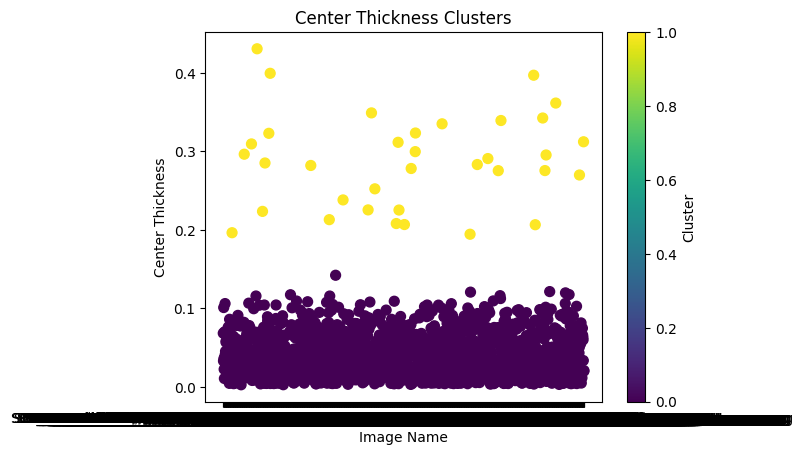

['SCL_OCT_dataset/label/XAQ_OD_I_img041_outcome.png',
 'SCL_OCT_dataset/label/LYR_OD_30m_img026_outcome.png']

In [51]:
cluster_center(results_df)

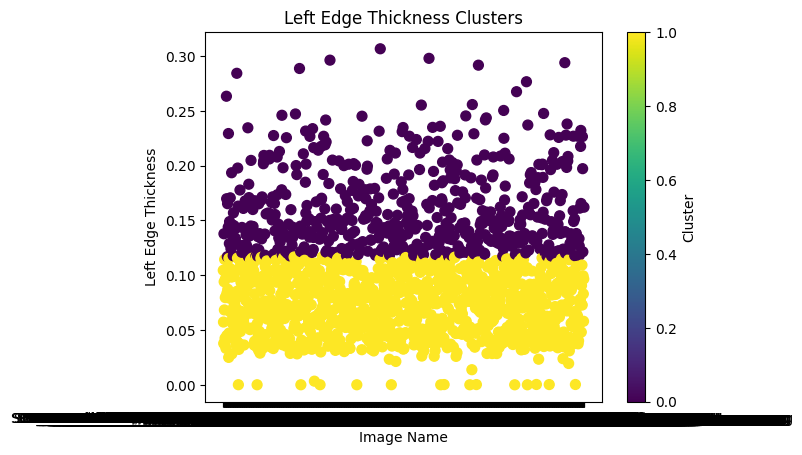

['SCL_OCT_dataset/label/ZJD_1h_img013_outcome.png',
 'SCL_OCT_dataset/label/XAQ_OD_30m_img052_outcome.png']

In [52]:
cluster_left(results_df)

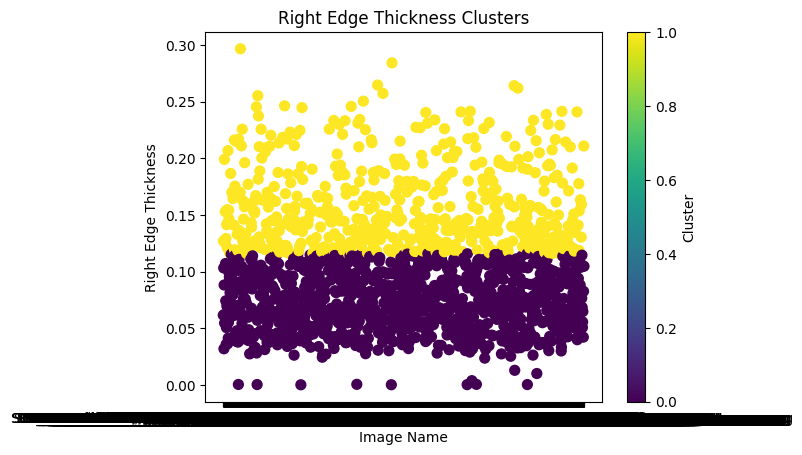

['SCL_OCT_dataset/label/XAQ_OD_I_img006_outcome.png',
 'SCL_OCT_dataset/label/XAQ_OD_30m_img056_outcome.png']

In [53]:
cluster_right(results_df)

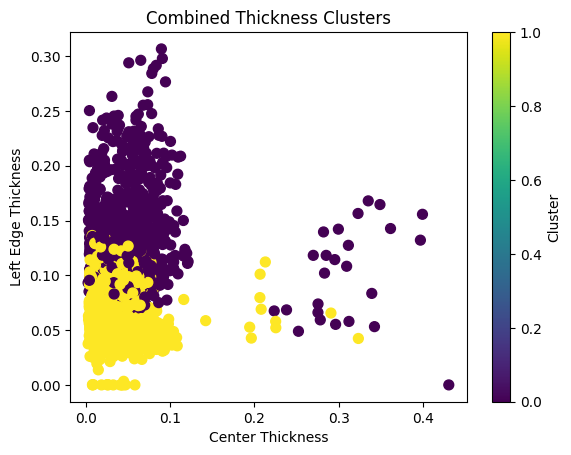

['SCL_OCT_dataset/label/PYY_OD_I_img023_outcome.png',
 'SCL_OCT_dataset/label/PYY_OS_I_img038_outcome.png']

In [54]:
cluster_all(results_df)